# Machine learning model

In this notebook we will build and deploy a Xgboost model for lifetime revenue forecasting using SageMaker.


#### 1. Preparing the data

- Reading and merging datasets
- Missing values
- Validation sample
- Categorical features

#### 2. Feature selection

There are nearly 50 features in our dataset, however, many have low predictive power, while others have a high correlation between them. In order to reduce the number of variables, we will use two wrapper methods for feature selection:

- Recursive Feature Elimination (RFE)
- Sequential Backward Selection (SBS)

Additionally, we use **Shap values** to evaluate selected features.

#### 3. Hyperparameter tuning

After selecting our features, we perform an extensive hyperparameter tuning process using SageMaker's Bayesian optimization algorithm. 

#### 4. SageMaker's model training

In this section we build the final model using SageMaker API.

#### 5. Batch inference and performance evaluation

The resulting model is used to perform batch inference on the train, validation (out-of-id) and test (out-of-time) samples. The results are ploted and compared with the baseline using different metrics and visualizations.

#### 6. Model deployment

Finally, we deploy the model as a SageMaker endpoint that can be used to make online predictions.

In [8]:
#!python3 -m conda install -c conda-forge shap -y

In [1]:
import io
import os
import gc
from datetime import datetime
import json
from urllib.parse import urlparse
import itertools

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_squared_log_error, mean_squared_error
from sklearn.feature_selection import RFE

import shap
from xgboost import XGBRegressor

import awswrangler as wr
from sagemaker.xgboost.estimator import XGBoost
import sagemaker
import boto3

sns.set()
pd.set_option("max_columns", 99)

def read_parquet_s3(bucket, filepath):
    buffer = io.BytesIO()
    s3 = boto3.resource('s3')
    obj = s3.Object(bucket, filepath)
    obj.download_fileobj(buffer)
    return pd.read_parquet(buffer)

## 1. Preparing the data


In [2]:
# create train set
bucket_ = "capstone-transaction-data"
train = read_parquet_s3(bucket_, "processed_data/train_features.parquet")
train_target = read_parquet_s3(bucket_, "preprocessed_data/train_target.parquet")
train = train.merge(train_target, on="id", how="left")
train["purchaseamount_90d"].fillna(0, inplace=True)
train.rename({"purchaseamount_90d": "target"}, axis=1, inplace=True)

# create test set
test = read_parquet_s3(bucket_, "processed_data/test_features.parquet")
test_target = read_parquet_s3(bucket_, "preprocessed_data/test_target.parquet")
test = test.merge(test_target, on="id", how="left")
test["purchaseamount_90d"].fillna(0, inplace=True)
test.rename({"purchaseamount_90d": "target"}, axis=1, inplace=True)

print(train.shape, test.shape)
train.head(2)

(288081, 51) (305007, 51)


,id,num_unique_date,max_transaction_amount,sum_amount,avg_transaction_amount,std_transaction_amount,chain,num_unique_dept,num_unique_brand,days_since_last_transaction,days_since_first_transaction,avg_daily_amount,unique_dates_to_days,avg_date_amount,std_date_amount,unique_dates_180d,transactions_count_180d,purchase_amount_sum_180d,avg_transaction_amount_180d,purchasequantity_sum_180d,time_weighted_amount_180d,unique_dates_90d,transactions_count_90d,purchase_amount_sum_90d,avg_transaction_amount_90d,purchasequantity_sum_90d,time_weighted_amount_90d,unique_dates_60d,transactions_count_60d,purchase_amount_sum_60d,avg_transaction_amount_60d,purchasequantity_sum_60d,time_weighted_amount_60d,unique_dates_30d,transactions_count_30d,purchase_amount_sum_30d,avg_transaction_amount_30d,purchasequantity_sum_30d,time_weighted_amount_30d,recency,dslt_to_recency,dslt_to_dsft,recency_to_unique_dates,dslt_to_rtud,sum_amount_to_dsft,sum_amount_to_recency,amount_30_to_180_rate,amount_60_to_180_rate,amount_90_to_180_rate,amount_30_to_90_rate,target
0,12262064,120,65.959999,2295.729980,4.114212,4.54858,95,65,218,1,213,10.778075,0.563380,19.131083,18.765202,109.0,524.0,2132.280029,4.069237,609.0,538.865601,54.0,267.0,1055.380005,3.952734,290.0,319.114532,37.0,185.0,749.809998,4.053027,201.0,249.026154,19.0,93.0,337.389984,3.627849,102.0,140.975647,212,0.004695,0.004695,1.766667,0.361446,10.72771,10.828915,0.158156,0.351482,0.494722,0.319383,838.989990
1,12277270,93,24.980000,3601.310059,5.789887,4.24051,95,55,167,2,210,17.149096,0.442857,38.723763,41.318462,81.0,539.0,3129.820068,5.806716,623.0,840.181580,38.0,262.0,1507.849976,5.755153,310.0,509.219116,24.0,188.0,1091.979980,5.808404,226.0,413.054291,12.0,116.0,660.409973,5.693190,144.0,299.235992,208,0.009569,0.009569,2.236559,0.617940,17.06782,17.313992,0.210938,0.348784,0.481615,0.437691,1505.689941


### Missing values and infinite

In [3]:
# fixing infinite and nans
not_num = train.isin([np.nan, np.inf, -np.inf]).sum()
not_num[not_num > 0]

avg_daily_amount          126
unique_dates_to_days      126
sum_amount_to_recency    1879
dtype: int64

In [4]:
# replace with a special value (-1)
train.replace(np.inf, -1, inplace=True)
test.replace(np.inf, -1, inplace=True)

### Validation sample

Using our out-of-time sample (test set) for feature selection might lead to overfitting. Therefore we will be using a validation sample from our train set for feature selection and hyperparameter tuning. Note that this is only possible because the target distribution for train and out-of-time samples is close, meaning that the revenue is probably stable over time.

In [5]:
train, valid = train_test_split(train, train_size=0.7, random_state=21)

### Categorical features

Unlike LightGBM and Catboost, XGBoost doesn't handle categorical features by itself. The only categorical feature in this dataset is the store chain, but using one-hot encode is not the best approach since there are 130 different stores, so we will be using a **target encoding** method. We use a smoothing parameter to avoid overfitting as described in [this post](https://maxhalford.github.io/blog/target-encoding/).

Note: we could have left the chain as an integer value, but the algorithm would assume that there is a numerical order between the stores.

In [6]:
def calc_smooth_mean(df, feature_column, target_column, weight):
    global_mean = df[target_column].mean()

    # Compute the number of values and the mean of each group
    agg = df.groupby(feature_column)[target_column].agg(['count', 'mean'])
    counts = agg['count']
    means = agg['mean']

    # Compute the "smoothed" means
    smooth = (counts * means + weight * global_mean) / (counts + weight)
    
    def transform(new_df):
        # apply the mean encoding
        return new_df.loc[:, feature_column].map(smooth)

    return transform

encoder = calc_smooth_mean(train, "chain", "target", weight=10)
train.loc[:, "chain_encode"] = encoder(train)
valid.loc[:, "chain_encode"] = encoder(valid)
test.loc[:, "chain_encode"] = encoder(test)

In [7]:
init_features = np.array([c for c in train.columns if c not in ["id", "target", "chain"]])

## 1. Feature selection

### Gamma objective

Using the reg:gamma objective can improve our model since the target distribution is close to a gamma distribution (see the exploratory analysis). However, this objective only works with positive numbers, so we add a small constant to avoid zeros in the target.

In [8]:
def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

def rmsle(y_true, y_pred):
    return np.sqrt(mean_squared_log_error(y_true, y_pred))

def scorer(model, X, y):
    y_pred = model.predict(X)
    return rmsle(y, y_pred)

constant = 0.01
train["target"] += constant
valid["target"] += constant
test["target"] += constant

### Initial model

Before the feature selection process, we test a few different hyperparameters by hand to avoid a heavy underfitting/overfitting. This is also useful in order to select the hyperparameters range for the next section (hyperparameter optimzation).

In [22]:
xgb_estimator = XGBRegressor(
    objective='reg:gamma',
    max_depth=8,
    learning_rate=0.1,
    subsample=0.85,
    colsample_by_tree=0.8,
    reg_lambda=4,
    min_child_weight=10,
    n_estimators=200,
    importance_type='gain',
    n_jobs=8,
    random_state=21,
    verbosity=0,
)
xgb_estimator.fit(train[init_features], y=train["target"])

# initial scores for each sample
_train_score = scorer(xgb_estimator, train[init_features], train["target"])
_valid_score = scorer(xgb_estimator, valid[init_features], valid["target"])
_test_score = scorer(xgb_estimator, test[init_features], test["target"])
print("RMSLE train score: {:.4f}".format(_train_score))
print("RMSLE valid score: {:.4f}".format(_valid_score))
print("RMSLE test score: {:.4f}".format(_test_score))

RMSLE train score: 0.5531
RMSLE valid score: 0.5909
RMSLE test score: 0.5945


### Recursive Feature Elimination (RFE)
The goal of recursive feature elimination is to select features by recursively considering smaller and smaller sets of features. First, the estimator is trained on the initial set of features and the importance of each feature is obtained through the feature_importances_ property. Then, the least important features are pruned from current set of features. That procedure is recursively repeated on the pruned set until the desired number of features to select is reached.

In [26]:
rankings = []
for n_features in [6, 10, 12, 16, 20, 25, 28, 30, 36]:
    rfe = RFE(xgb_estimator, n_features_to_select=n_features, step=2, verbose=0)
    rfe.fit(train[init_features], train["target"])
    score = scorer(rfe, valid[init_features], valid["target"])  # validation score
    print("Number of features: {}, RMSLE: {:.4f}".format(n_features, score))
    rankings.append(rfe.ranking_)

Number of features: 6, RMSLE: 0.6004
Number of features: 10, RMSLE: 0.5961
Number of features: 12, RMSLE: 0.5961
Number of features: 16, RMSLE: 0.5943
Number of features: 20, RMSLE: 0.5935
Number of features: 25, RMSLE: 0.5917
Number of features: 28, RMSLE: 0.5922
Number of features: 30, RMSLE: 0.5911
Number of features: 36, RMSLE: 0.5913


We will keep 25 features and plot the rank, feature importance and correlation with the target for all the initial features:

In [35]:
target_corr = train[init_features].corrwith(train.target, method="spearman")

table = pd.DataFrame({
    "feature": init_features,
    "rank": rankings[-3],
    "target_correlation": target_corr,
    "importance": xgb_estimator.feature_importances_
})
table = table.reset_index(drop=True).sort_values(by="importance", ascending=False)
display(table)

,feature,rank,target_correlation,importance
42,sum_amount_to_dsft,1,0.859768,0.637369
9,avg_daily_amount,1,0.858932,0.073031
15,purchase_amount_sum_180d,1,0.840621,0.031013
21,purchase_amount_sum_90d,1,0.843488,0.030431
18,time_weighted_amount_180d,1,0.848699,0.016223
43,sum_amount_to_recency,1,0.850585,0.013724
27,purchase_amount_sum_60d,1,0.835818,0.011619
48,chain_encode,1,0.335155,0.009408
33,purchase_amount_sum_30d,1,0.799270,0.008630
24,time_weighted_amount_90d,1,0.838481,0.008496


Next we plot a heatmap with the spearman correlation between the remaining 25 features:

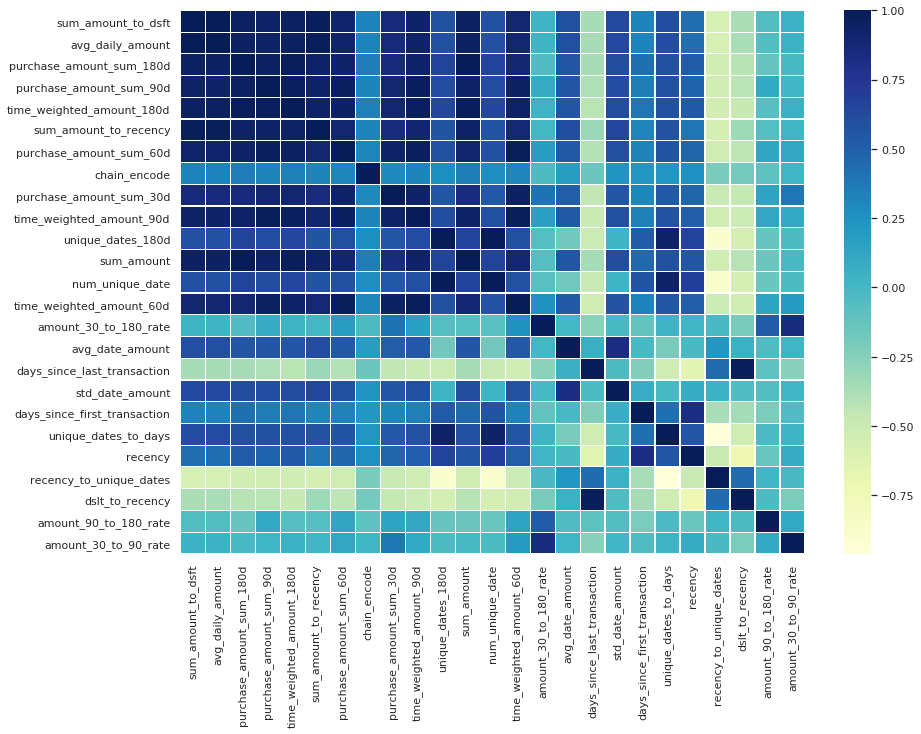

In [38]:
features = [f.feature for f in table.itertuples() if f.rank == 1]
corr = train[features].corr(method="spearman")
plt.figure(figsize=(14, 10))
_ = sns.heatmap(corr, annot=False, linewidths=.1, cmap="YlGnBu")

### Sequential Feature Selection for highly correlated features

As we can see from the heatmap, there are many highly correlated features. Instead of removing some of these features randomly, we will fit one model after removing every single feature and select the one with the best score. In the next stage we repeat the same process with a smaller subset of features. This procedure is also called Sequential Backward Selection (SBS), but we are only considering highly correlated features since it is computationally expensive.

In [45]:
corr[corr == 1] = 0  # ignore diagonal
max_corr = corr.max()
subset = max_corr[max_corr > 0.85].index
print("Number of features with high correlation:", len(subset))

Number of features with high correlation: 16


In [66]:
def backward_selection(tr, vl, all_features, eval_features, target, rounds, sample_fr=1):
    """Sequential Backward Feature Selection (SBS) using a validation sample.
    
    Parameters
    -----------
    tr: pd.DataFrame
        Training dataset with all initial features
    vl: pd.DataFrame
        Validation dataset
    all_features: list
        All initial features used in the model
    eval_features: list
        List of features that will be evaluated
    target: str
        Target column name
    rounds: int
        Number of iterations (and removed features)
    sample_fr: float
        Sample fraction: if less than 1, uses a sample
        from tr to train each model
    """
    scores = []
    removed = []
    sample = tr.sample(frac=sample_fr, random_state=21)
    
    for i in range(rounds):
        round_scores = []
        
        for feat in eval_features:
            if feat in removed:
                round_scores.append(999)
                continue
            
            cols = [c for c in all_features if c not in removed and c != feat]
            xgb_estimator.fit(sample[cols], sample[target])
            round_scores.append(scorer(xgb_estimator, vl[cols], vl[target]))
        
        removed_feature = eval_features[np.argmin(round_scores)]
        removed.append(removed_feature)
        scores.append(round_scores.copy())
        print("{}. Removed: {}, RMSLE score: {:.4f}".format(i+1, removed_feature, np.min(round_scores)))
        
    return removed, pd.DataFrame(scores, columns=eval_features)

In [60]:
drop_features, results = backward_selection(train, valid, features, subset, "target",
                                            rounds=14, sample_fr=0.3)

1. Removed: sum_amount, RMSLE score: 0.5921
2. Removed: num_unique_date, RMSLE score: 0.5926
3. Removed: purchase_amount_sum_30d, RMSLE score: 0.5924
4. Removed: avg_daily_amount, RMSLE score: 0.5924
5. Removed: unique_dates_to_days, RMSLE score: 0.5923
6. Removed: days_since_last_transaction, RMSLE score: 0.5918
7. Removed: sum_amount_to_recency, RMSLE score: 0.5916
8. Removed: purchase_amount_sum_180d, RMSLE score: 0.5923
9. Removed: purchase_amount_sum_60d, RMSLE score: 0.5920
10. Removed: unique_dates_180d, RMSLE score: 0.5925
11. Removed: purchase_amount_sum_90d, RMSLE score: 0.5926
12. Removed: time_weighted_amount_180d, RMSLE score: 0.5929
13. Removed: time_weighted_amount_90d, RMSLE score: 0.5933
14. Removed: time_weighted_amount_60d, RMSLE score: 0.5945


We remove nine more features to end up with 16 features:

In [69]:
features = [f for f in features if f not in drop_features[:9]]
print("Selected features:", features)

Selected features: ['sum_amount_to_dsft', 'purchase_amount_sum_90d', 'time_weighted_amount_180d', 'chain_encode', 'time_weighted_amount_90d', 'unique_dates_180d', 'time_weighted_amount_60d', 'amount_30_to_180_rate', 'avg_date_amount', 'std_date_amount', 'days_since_first_transaction', 'recency', 'recency_to_unique_dates', 'dslt_to_recency', 'amount_90_to_180_rate', 'amount_30_to_90_rate']


### Shap values and feature importance

Finally, we use the [Shap library](https://github.com/slundberg/shap) to analyze our main features for this model:

In [31]:
xgb_estimator.fit(train[features], y=train["target"])
explainer = shap.Explainer(xgb_estimator)
shap_values = explainer(test[features])

The plot below sorts features by the sum of SHAP value magnitudes over all samples, and uses SHAP values to show the distribution of the impacts each feature has on the model output:

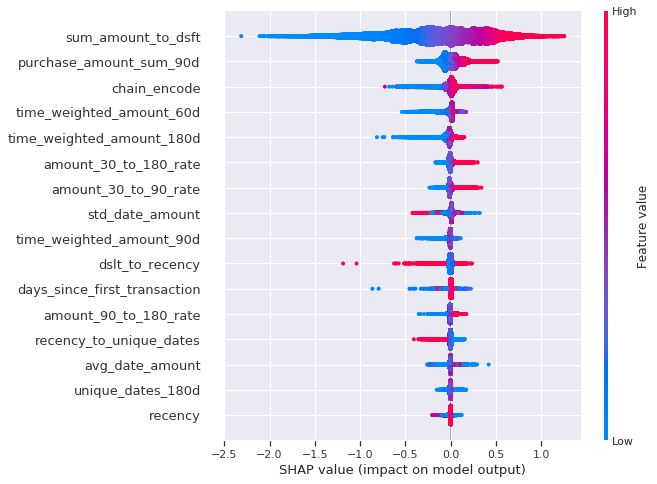

In [100]:
shap.plots.beeswarm(shap_values, max_display=16)

The first three features have the expected behaviour where high spending customer will have a higher future purchase amount. More recent spending is also rewarded from the fourth to the seventh feature. The std_date_amount is penalizing customers with a more unstable spending profile, while recency_to_unique_dates is rewarding a higher purchase frequency.

Some features are more complicated though, let's have a deeper look using scatter plots:

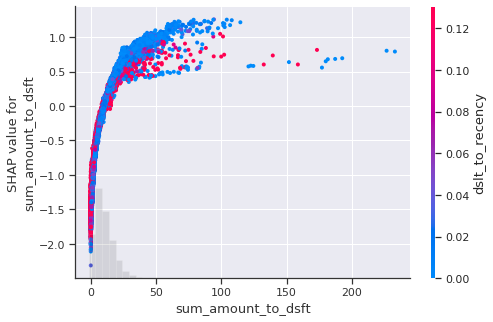

In [113]:
shap.plots.scatter(shap_values[:,"sum_amount_to_dsft"], color=shap_values)

Here we can see the interaction between **dslt_to_recency**, which had no meaningful direction on the impact plot, with the most important feature. This is showing that customers with high average spending are penalized if they haven't bought in a while.

In the next plot, we look at the avg_date_amount feature:

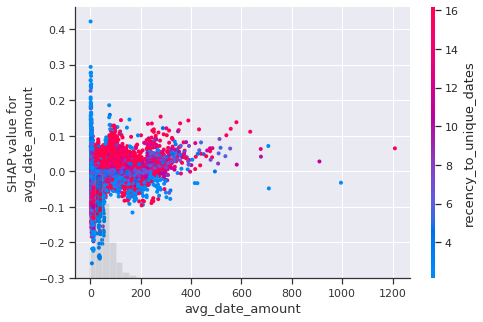

In [114]:
shap.plots.scatter(shap_values[:,"avg_date_amount"], color=shap_values)

Despite the noise, we can see that customers with a higher average spending per date are more prone to spend in the future, specially when looking at the interaction with the recency_to_unique_dates, which basically measures the purchase frequency.

Finally, we can compare the **average shap value** for each feature (left) with the **xgboost feature importance** (right):

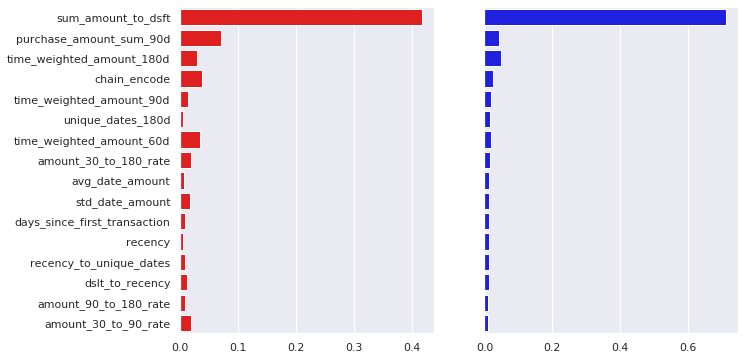

In [138]:
avg_shap = np.mean(np.abs(shap_values.values), axis=0)
fig, axes = plt.subplots(1, 2, figsize=(10, 6), sharey=True)
_ = sns.barplot(y=features, x=avg_shap, orient="h", ax=axes[0], color="red")
_ = sns.barplot(y=features, x=xgb_estimator.feature_importances_,
                orient="h", ax=axes[1], color="blue")

## 3. Hyperparameter tuning

Using the validation sample to score our model, we are going to perform hyperparameter optimization for the XGBoost algorithm with the built-in SageMaker's Tuner. To search for the best hyperparameters, SageMaker is using a Bayesian approach within this algorithm.

SageMaker's algorithms expects a csv file as input with the first column being the target variable and the remaining columns as features. This csv file must not have a header nor index:

In [10]:
session = sagemaker.Session()
bucket = session.default_bucket()
role = sagemaker.get_execution_role()
train_path = "s3://{}/{}/{}".format(bucket, "datasets", "train.csv")
valid_path = "s3://{}/{}/{}".format(bucket, "datasets", "valid.csv")
test_path = "s3://{}/{}/{}".format(bucket, "datasets", "test.csv")

In [147]:
cols = ["target"] + features
wr.s3.to_csv(df=train[cols], path=train_path, header=False, index=False)
wr.s3.to_csv(df=valid[cols], path=valid_path, header=False, index=False)
wr.s3.to_csv(df=test[cols],  path=test_path,  header=False, index=False)

{'paths': ['s3://sagemaker-us-east-2-165065549497/datasets/test.csv'],
 'partitions_values': {}}

As mentioned in the Baseline notebook, we will be using the Root Mean Squared Log Error (RMSLE) to evaluate our model. However, this estimator does not support custom metrics for HPO due to an issue with the current container (as described [here](https://github.com/aws/sagemaker-xgboost-container/issues/121)). Therefore, we will perform the search using RMSE instead.

In [12]:
from sagemaker.tuner import IntegerParameter, ContinuousParameter, HyperparameterTuner

# wrapper around the location of our train and validation data
train_input = sagemaker.session.TrainingInput(train_path, content_type="csv")
valid_input = sagemaker.session.TrainingInput(valid_path, content_type="csv")

output_path = "s3://{}/{}/output".format(bucket, "xgb_results")

hyperparams = {
    "objective": "reg:gamma",
    "eval_metric_1": "rmsle",
    "eval_metric_2": "rmse",
}

# construct a xgb estimator from custom script
xgb_estimator = XGBoost(
    entry_point="xgb/xgb_train.py",
    framework_version="1.3-1",
    hyperparameters=hyperparams,
    role=role,
    instance_count=1,
    instance_type="ml.c5.xlarge",
    output_path=output_path,
)

hyperparams_range = {
    'eta': ContinuousParameter(0.01, 0.1),
    'gamma': IntegerParameter(0, 10),
    'max_depth': IntegerParameter(6, 20),
    'min_child_weight': IntegerParameter(1, 10),
    'subsample': ContinuousParameter(0.6, 1),
    'reg_lambda': ContinuousParameter(0, 2),
    'reg_alpha': ContinuousParameter(0, 2),
    'num_round': IntegerParameter(200, 1000),
}

xgb_hyperparameter_tuner = HyperparameterTuner(estimator = xgb_estimator,
                                               objective_metric_name = 'validation:rmse',
                                               objective_type = 'Minimize',
                                               max_jobs = 200, # The total number of models to train
                                               max_parallel_jobs = 5, # The number of models to train in parallel
                                               hyperparameter_ranges = hyperparams_range)

In [5]:
xgb_hyperparameter_tuner.fit({'train': train_input, 'validation': valid_input})
xgb_hyperparameter_tuner.wait()

...................................................................................................................................................................................................................................................................................................................................................................................................................................!
!


## 4. Retraining the model

Now we fit the model with the best hyperparameters:

In [14]:
hyperparams = {
    "max_depth": "18",
    "eta": "0.014712",
    "gamma": "0",
    "min_child_weight": "4",
    "subsample": "0.68002",
    "reg_alpha": "0.6847",
    "reg_lambda": "0.5041",
    "objective": "reg:gamma",
    "num_round": "745",
    "verbosity": "2",
    "eval_metric_1": "rmsle",
    "eval_metric_2": "rmse",
}

output_path = "s3://{}/{}/output".format(bucket, "xgb_results_06")

# construct a xgb estimator from custom script
xgb_estimator = XGBoost(
    entry_point="xgb/xgb_train.py",
    framework_version="1.3-1",
    hyperparameters=hyperparams,
    role=role,
    instance_count=1,
    instance_type="ml.m5.xlarge",
    output_path=output_path,
)
xgb_estimator.fit({"train": train_input, "validation": valid_input}, logs="None")


2021-09-15 13:33:33 Starting - Starting the training job
2021-09-15 13:33:35 Starting - Launching requested ML instances.........
2021-09-15 13:34:27 Starting - Preparing the instances for training...............
2021-09-15 13:35:48 Downloading - Downloading input data...
2021-09-15 13:36:09 Training - Downloading the training image....
2021-09-15 13:36:32 Training - Training image download completed. Training in progress..............................................................................
2021-09-15 13:43:04 Uploading - Uploading generated training model....
2021-09-15 13:43:27 Completed - Training job completed


## 5. Batch inference and model performance

Now that we have a trained model, we can make predictions for the three samples (dev, validation and out-of-time) to evaluate our model. To do this, we will make use of SageMaker's Batch Transform functionality. To start with, we need to build a transformer object from our fited model:

In [15]:
train_path_no_target = "s3://{}/{}/{}".format(bucket, "datasets", "train_no_target.csv")
valid_path_no_target = "s3://{}/{}/{}".format(bucket, "datasets", "valid_no_target.csv")
test_path_no_target = "s3://{}/{}/{}".format(bucket, "datasets", "test_no_target.csv")

In [151]:
wr.s3.to_csv(df=train[features], path=train_path_no_target, header=False, index=False)
wr.s3.to_csv(df=valid[features], path=valid_path_no_target, header=False, index=False)
wr.s3.to_csv(df=test[features],  path=test_path_no_target,  header=False, index=False)

{'paths': ['s3://sagemaker-us-east-2-165065549497/datasets/test_no_target.csv'],
 'partitions_values': {}}

In [16]:
xgb_estimator = sagemaker.estimator.Estimator.attach("sagemaker-xgboost-2021-09-15-13-33-33-229")


2021-09-15 13:43:39 Starting - Preparing the instances for training
2021-09-15 13:43:39 Downloading - Downloading input data
2021-09-15 13:43:39 Training - Training image download completed. Training in progress.
2021-09-15 13:43:39 Uploading - Uploading generated training model
2021-09-15 13:43:39 Completed - Training job completed


In [17]:
output_path_pred = "s3://{}/{}".format(bucket, "batchPredictions")
xgb_transformer = xgb_estimator.transformer(1, "ml.m5.large", accept="text/csv",
                                            strategy="MultiRecord", output_path=output_path_pred)

Call the transform method to make predictions for each csv file:

In [18]:
# start a transform job
xgb_transformer.transform(train_path_no_target, data_type="S3Prefix",
                          split_type="Line", content_type="text/csv", logs=False)
xgb_transformer.wait(logs=False)

.............................................................!
!


In [19]:
xgb_transformer.transform(valid_path_no_target, data_type="S3Prefix",
                          split_type="Line", content_type="text/csv", logs=False)
xgb_transformer.wait(logs=False)

........................................................!
!


In [20]:
xgb_transformer.transform(test_path_no_target, data_type="S3Prefix",
                          split_type="Line", content_type="text/csv", logs=False)
xgb_transformer.wait(logs=False)

...............................................................!
!


Now we can load these files and compare against the actual target:

In [21]:
def get_csv_output_from_s3(s3uri, file_name):
    parsed_url = urlparse(s3uri)
    bucket_name = parsed_url.netloc
    prefix = parsed_url.path[1:]
    s3 = boto3.resource("s3")
    obj = s3.Object(bucket_name, "{}/{}".format(prefix, file_name))
    return obj.get()["Body"].read().decode("utf-8")

train_output = get_csv_output_from_s3(output_path_pred, "train_no_target.csv.out")
valid_output = get_csv_output_from_s3(output_path_pred, "valid_no_target.csv.out")
test_output = get_csv_output_from_s3(output_path_pred, "test_no_target.csv.out")

train_pred = pd.read_csv(io.StringIO(train_output), sep=",", header=None, squeeze=True)
valid_pred = pd.read_csv(io.StringIO(valid_output), sep=",", header=None, squeeze=True)
test_pred  = pd.read_csv(io.StringIO(test_output),  sep=",", header=None, squeeze=True)
print(train_pred.shape, valid_pred.shape, test_pred.shape)

(201656,) (86425,) (305007,)


### RMSLE and RMSE

Final scores for Root Mean Squared Log Error (RMSLE) and Root Mean Squared Error (RMSE):

In [22]:
final_scores = pd.DataFrame({
    "RMSLE": [
        rmsle(train.target, train_pred),
        rmsle(valid.target, valid_pred),
        rmsle(test.target, test_pred)
    ],
    "RMSE": [
        rmse(train.target, train_pred),
        rmse(valid.target, valid_pred),
        rmse(test.target, test_pred)
    ]
}, index=["training", "validation", "test"])
display(final_scores)

,RMSLE,RMSE
training,0.443644,312.524712
validation,0.582672,376.770060
test,0.562691,340.979307


The test score is better than our baseline (0.62). One interesting point is that the test error (out-of-time sample) is lower than the validation error (out-of-id sample).

The next plot shows the predicted value vs the actual target:

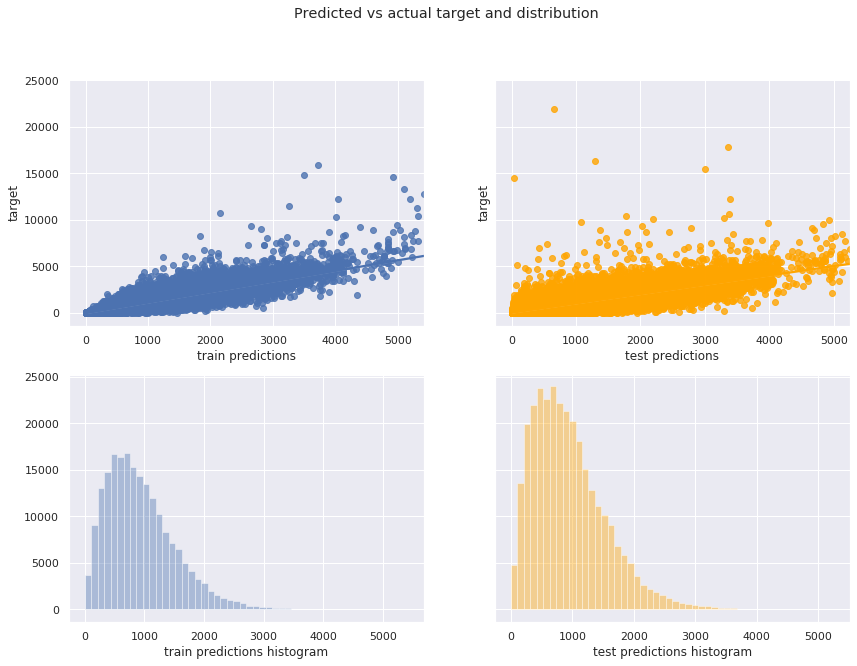

In [23]:
fig, axes = plt.subplots(2, 2, figsize=(14, 10), sharey=True)
axes = axes.flatten()
fig.suptitle('Predicted vs actual target and distribution')
sns.regplot(x=train_pred, y=train.target, ax=axes[0])
sns.regplot(x=test_pred, y=test.target, ax=axes[1], color="orange")
sns.distplot(train_pred, kde=False, ax=axes[2])
sns.distplot(test_pred, kde=False, ax=axes[3], color="orange")
_ = axes[0].set(xlabel='train predictions')
_ = axes[1].set(xlabel='test predictions')
_ = axes[2].set(xlabel='train predictions histogram')
_ = axes[3].set(xlabel='test predictions histogram')

### New customers

The performance for new customers (ids in the test set that were not in the train set) is also stable and very close to our validation sample (out-of-id):

In [24]:
test["predictions"] = test_pred
new_customers = test[~test.id.isin(train.id.values)]
rmsle_new_customers = rmsle(new_customers.target, new_customers.predictions)
print("There are {} new customers in the test set".format(len(new_customers)))
print("RMSLE for new customers only: {:.4f}".format(rmsle_new_customers))

There are 103351 new customers in the test set
RMSLE for new customers only: 0.5940


### Churning customers

We can also compare the predictions distribution for churning customers (orange) against non-churning customers (blue):

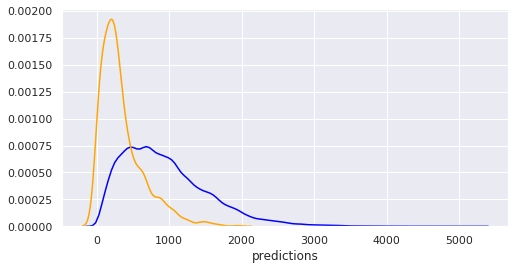

In [25]:
test["churn"] = test.target.apply(lambda x: 1 if x < 0.1 else 0)
plt.figure(figsize=(8, 4))
_ = sns.distplot(test.loc[test.churn == 0, "predictions"], hist=False, color="blue")
_ = sns.distplot(test.loc[test.churn == 1, "predictions"], hist=False, color="orange")

## 6. Model deployment

Now we can use the deploy method to create an endpoint api for making online predictions with our model. This method returns a XGBoostPredictor object, which accepts libsvm and csv data as input. The default serializer is the libsvm, so we need to pass a CSVSerializer object to this method:

In [113]:
predictor = xgb_estimator.deploy(
    initial_instance_count=1, instance_type="ml.t2.medium",
    serializer=sagemaker.serializers.CSVSerializer(content_type='text/csv')
)

-----------!

In [115]:
# Testing the endpoint with sample data
train.reset_index().loc[:10, features].to_csv("sample_data.csv", index=False, header=False)
with open("sample_data.csv", "r") as f:
    payload = f.read()

In [116]:
# Make ten predictions using the endpoint
sample_predictions = predictor.predict(payload)
sample_predictions

b'420.0600891113281,476.5772705078125,787.4234008789062,843.4796142578125,855.1921997070312,814.732421875,864.5066528320312,816.8322143554688,839.1279907226562,831.0686645507812,546.3779296875'

## Conclusion

In this notebook, we built an end-to-end XGBoost model for Lifetime Revenue Prediction (LTR). We also analyze the direction of every feature (SHAP values) as well as the final results. The model can be used for online predictions through the endpoint created in the last step, however, an analytical database with updated features would be necessary. To update those features, it is possible to use an ETL process (AWS Glue for instance) running every week and aggregating data from a transactional database.

From a model perspective, it is important to monitor performance over time. Most features are limited to a specific time window (last 180 days for instance) to avoid feature drifting, but it is critical to verify if the distribution remains the same over time.